In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from langdetect import detect
import csv
import requests
import urllib2
from lxml import html, etree
import json

import warnings; warnings.simplefilter('ignore')

# Load Data

In [3]:
# Channel stats
dfData = pd.read_csv('../data/channel_lang_final.csv')

# All Channels
dfChannel = pd.read_csv('../data/channelStats.csv')

In [4]:
dfData = dfData.merge(dfChannel,on='Channel Id',how='left')
dfData.rename(columns={'Unnamed: 0':'rowHash'}, inplace=True)

# Get Previous View Count

In [5]:
dfData_en = dfData[dfData["Lang"] == 'en']

In [6]:
dfData_single_en = dfData_en[dfData_en.groupby('Channel Id')['Channel Id'].transform(len) == 1]

In [7]:
dfData_multiple_en = dfData_en[dfData_en.groupby('Channel Id')['Channel Id'].transform(len) > 1]

In [8]:
dfData_multiple_en['rowHash'] = [x for x in range(dfData_multiple_en.shape[0])]

In [9]:
uniqueChannelID = list(set(dfData_multiple_en['Channel Id'].tolist()))

In [11]:
cg = dfData_multiple_en
def getNextHashCode(x):
    return x + 1
cg['nextHash'] = cg['rowHash'].apply(getNextHashCode)

# Set up first DataFrame

In [12]:
cg1 = dfData_multiple_en
cg1 = dfData_multiple_en[dfData_multiple_en['Channel Id'] == uniqueChannelID[0]]
cg1 = cg1.drop(cg1.index[cg1.shape[0]-1])
cg1['nextHash'] = cg1['rowHash'].apply(getNextHashCode)


In [13]:
cg1['nextHash']

5     1
27    2
30    3
Name: nextHash, dtype: int64

In [14]:
len(uniqueChannelID)

3803

# Concatenate all Unique ID

In [15]:
import progressbar
bar = progressbar.ProgressBar()
for channel in bar(uniqueChannelID):
    dftemp = dfData_multiple_en[dfData_multiple_en['Channel Id'] == channel]
    dftemp['nextHash'] = dftemp['rowHash'].apply(getNextHashCode)
    cg1 = cg1.dropna()
    cg1 = cg1.append(dftemp[:-1])
    

100% (3803 of 3803) |#####################| Elapsed Time: 0:09:20 Time: 0:09:20


In [16]:
cg1 = cg1.drop_duplicates(subset='Id', keep="first")
cg1[['rowHash','nextHash']]
cg1.to_csv("row_Hash_in_full_data.csv")

In [17]:
header = ["nextHash", "PrevCommentCount", "PrevDislikeCount", "PrevLikeCount","PrevPublishedAt","PrevViewCount","PrevTitle"]
nextHashDF = dfData_multiple_en[['rowHash','CommentCount','DislikeCount','LikeCount','PublishedAt','ViewCount','Title']]
nextHashDF.to_csv("next_hash_map.csv")

In [18]:
nextHashDF.columns = header

# Map Previous Values

In [33]:
cg2 = cg1.drop_duplicates(subset='Id', keep="first")

In [34]:
mergeDF = cg1.merge(nextHashDF,on='nextHash',how='left')

In [35]:
mergeDF.to_csv("Merged_data.csv")

In [36]:
mergeDF.shape[0]

92291

In [37]:
mergeDF.head()

,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,...,subscriberCount,channelVideoCount,channelViewCount,nextHash,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle
0,0,Scp3JH3eVLw,Depeche Mode It's No Good,DANCA MUITO.,0,0,18,0,0,2017-06-25T19:12:16.000Z,...,10296,37,8251061,1,0,2,14,2012-03-28T18:01:31.000Z,3911,the best of Jay cutler Dorian Yates
1,1,wLqmkz6u8G4,the best of Jay cutler Dorian Yates,Jay cutler e Dorian Yates,14,2,3911,0,0,2012-03-28T18:01:31.000Z,...,10296,37,8251061,2,5,2,8,2010-08-23T16:12:50.000Z,3853,Iron Man Andy photos NO PAIN NO GAIN
2,2,nKMsh79uOcM,Iron Man Andy photos NO PAIN NO GAIN,Iron Man Andy muscle NO PAIN NO GAIN,8,2,3853,0,5,2010-08-23T16:12:50.000Z,...,10296,37,8251061,3,0,2,3,2010-05-17T10:15:48.000Z,1392,the mission SEVERINA
3,4,E--7XtuuqAg,Mooring Anchor Carry 120kg at Papar Strongestm...,Only manage 11 meters,0,0,56,0,0,2016-10-10T15:07:16.000Z,...,288,79,123988,5,0,0,0,2016-10-10T15:01:02.000Z,74,Tire Flip 450kg at Papar Strongestman 2016
4,5,fdsppIOelPw,Tire Flip 450kg at Papar Strongestman 2016,450kg x 5 flips,0,0,74,0,0,2016-10-10T15:01:02.000Z,...,288,79,123988,6,0,0,0,2016-10-10T14:59:15.000Z,46,Farmer Walk 125kg each hand at Papar Strongest...


In [41]:
def drop_obvious_features(dfData):
    dfData = dfData.drop(['LikeCount','DislikeCount','CommentCount'],axis = 1)
    return dfData
def drop_useless_features(dfData):
    dfData= dfData.drop(['rowHash','Id','Title','Description','FavoriteCount','nextHash','Lang','PrevPublishedAt',
                         'Channel Title','Channel Id','PrevTitle'],axis = 1)
    return dfData
def feature_engineer(dfData):
    dfData['PublishedYear'] = dfData['PublishedAt'].apply(lambda x: x[:4])
    dfData['ChannelAge'] =  dfData['publishedAt'].apply(lambda x: x[:4])
    dfData = dfData.drop(['PublishedAt','publishedAt'],axis = 1)
    return dfData

In [42]:
mergeDF.columns

Index([u'rowHash', u'Id', u'Title', u'Description', u'LikeCount',
       u'DislikeCount', u'ViewCount', u'FavoriteCount', u'CommentCount',
       u'PublishedAt', u'Channel Id', u'Channel Title', u'Lang',
       u'publishedAt', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'nextHash', u'PrevCommentCount',
       u'PrevDislikeCount', u'PrevLikeCount', u'PrevPublishedAt',
       u'PrevViewCount', u'PrevTitle', u'PublishedYear', u'ChannelAge'],
      dtype='object')

In [43]:
df = drop_obvious_features(drop_useless_features(feature_engineer(mergeDF)))

In [44]:
df.columns

Index([u'ViewCount', u'subscriberCount', u'channelVideoCount',
       u'channelViewCount', u'PrevCommentCount', u'PrevDislikeCount',
       u'PrevLikeCount', u'PrevViewCount', u'PublishedYear', u'ChannelAge'],
      dtype='object')

In [45]:
X, y = df.drop('ViewCount',axis = 1) , np.log1p(df['ViewCount'])

In [46]:
def checkForNull(X,y):
    X = X.as_matrix().astype(float)
    print "Check For Null Values"
    for i in range(0,len(df.columns)-1):
        print np.any(np.isinf(X[:,i]))
    print "Check for Pred:"
    y = y.as_matrix().astype(float)
    print np.any(np.isinf(y))
checkForNull(X,y)

Check For Null Values
False
False
False
False
False
False
False
False
False
Check for Pred:
False


In [47]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, test_size=0.25)

In [48]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.66866731222485987

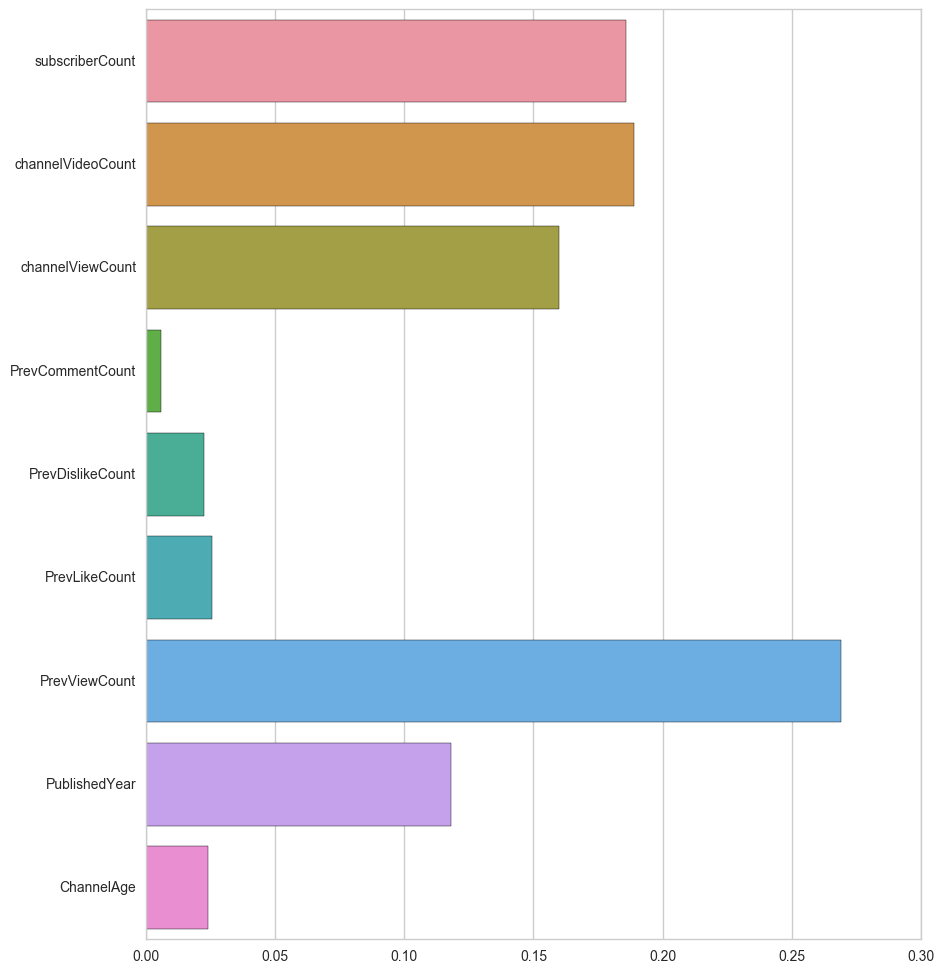

In [49]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,12))
sns.barplot(x=reg.feature_importances_, y=X.columns)

In [50]:
reg = XGBRegressor()
train_X['ChannelAge'] = train_X['ChannelAge'].astype(int)
test_X['ChannelAge'] = test_X['ChannelAge'].astype(int)
train_X['PublishedYear'] = train_X['PublishedYear'].astype(int)
test_X['PublishedYear'] = test_X['PublishedYear'].astype(int)
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.66869807226261546

# Bring back in channels with only 1 video

In [51]:
dfData_single_en['nextHash'] = ""
singleDF = dfData_single_en.merge(nextHashDF,on='nextHash',how='left').fillna(0)

In [52]:
mergeDF = mergeDF.drop(['PublishedYear','ChannelAge'],axis = 1)

In [53]:
singleDF = singleDF[mergeDF.columns]

In [54]:
allDF = mergeDF.append(singleDF)

In [55]:
allDF.head()

,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,...,subscriberCount,channelVideoCount,channelViewCount,nextHash,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle
0,0,Scp3JH3eVLw,Depeche Mode It's No Good,DANCA MUITO.,0,0,18,0,0,2017-06-25T19:12:16.000Z,...,10296,37,8251061,1,0.0,2.0,14.0,2012-03-28T18:01:31.000Z,3911.0,the best of Jay cutler Dorian Yates
1,1,wLqmkz6u8G4,the best of Jay cutler Dorian Yates,Jay cutler e Dorian Yates,14,2,3911,0,0,2012-03-28T18:01:31.000Z,...,10296,37,8251061,2,5.0,2.0,8.0,2010-08-23T16:12:50.000Z,3853.0,Iron Man Andy photos NO PAIN NO GAIN
2,2,nKMsh79uOcM,Iron Man Andy photos NO PAIN NO GAIN,Iron Man Andy muscle NO PAIN NO GAIN,8,2,3853,0,5,2010-08-23T16:12:50.000Z,...,10296,37,8251061,3,0.0,2.0,3.0,2010-05-17T10:15:48.000Z,1392.0,the mission SEVERINA
3,4,E--7XtuuqAg,Mooring Anchor Carry 120kg at Papar Strongestm...,Only manage 11 meters,0,0,56,0,0,2016-10-10T15:07:16.000Z,...,288,79,123988,5,0.0,0.0,0.0,2016-10-10T15:01:02.000Z,74.0,Tire Flip 450kg at Papar Strongestman 2016
4,5,fdsppIOelPw,Tire Flip 450kg at Papar Strongestman 2016,450kg x 5 flips,0,0,74,0,0,2016-10-10T15:01:02.000Z,...,288,79,123988,6,0.0,0.0,0.0,2016-10-10T14:59:15.000Z,46.0,Farmer Walk 125kg each hand at Papar Strongest...


# Repeat Experiment

In [56]:
df = drop_obvious_features(drop_useless_features(feature_engineer(allDF)))

In [57]:
X, y = df.drop('ViewCount',axis = 1) , np.log1p(df['ViewCount'])

In [58]:
reg = GradientBoostingRegressor()
reg.fit(train_X, train_y)
reg.score(test_X, test_y)

0.66865969784119605

In [59]:
allDF.to_csv("All_data.csv")

In [60]:
allDF.head()

,rowHash,Id,Title,Description,LikeCount,DislikeCount,ViewCount,FavoriteCount,CommentCount,PublishedAt,...,channelViewCount,nextHash,PrevCommentCount,PrevDislikeCount,PrevLikeCount,PrevPublishedAt,PrevViewCount,PrevTitle,PublishedYear,ChannelAge
0,0,Scp3JH3eVLw,Depeche Mode It's No Good,DANCA MUITO.,0,0,18,0,0,2017-06-25T19:12:16.000Z,...,8251061,1,0.0,2.0,14.0,2012-03-28T18:01:31.000Z,3911.0,the best of Jay cutler Dorian Yates,2017,2008
1,1,wLqmkz6u8G4,the best of Jay cutler Dorian Yates,Jay cutler e Dorian Yates,14,2,3911,0,0,2012-03-28T18:01:31.000Z,...,8251061,2,5.0,2.0,8.0,2010-08-23T16:12:50.000Z,3853.0,Iron Man Andy photos NO PAIN NO GAIN,2012,2008
2,2,nKMsh79uOcM,Iron Man Andy photos NO PAIN NO GAIN,Iron Man Andy muscle NO PAIN NO GAIN,8,2,3853,0,5,2010-08-23T16:12:50.000Z,...,8251061,3,0.0,2.0,3.0,2010-05-17T10:15:48.000Z,1392.0,the mission SEVERINA,2010,2008
3,4,E--7XtuuqAg,Mooring Anchor Carry 120kg at Papar Strongestm...,Only manage 11 meters,0,0,56,0,0,2016-10-10T15:07:16.000Z,...,123988,5,0.0,0.0,0.0,2016-10-10T15:01:02.000Z,74.0,Tire Flip 450kg at Papar Strongestman 2016,2016,2011
4,5,fdsppIOelPw,Tire Flip 450kg at Papar Strongestman 2016,450kg x 5 flips,0,0,74,0,0,2016-10-10T15:01:02.000Z,...,123988,6,0.0,0.0,0.0,2016-10-10T14:59:15.000Z,46.0,Farmer Walk 125kg each hand at Papar Strongest...,2016,2011
